This Notebook is meant to generate a platon eclipse depth spectrum.
The output of platon will then be used as input into pandexo.

In [16]:
# Imports
from platon.TP_profile import Profile
from platon.eclipse_depth_calculator import EclipseDepthCalculator
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO

import pandexo.engine.justplotit as jpi
import pickle as pk
from IPython.display import HTML



In [17]:
# Constants
from platon.constants import M_jup, R_jup, R_sun, M_earth

# Location of the data folder in which all output will be saved.
datapath = "/home/noud333/bachelorproject/data"

# name of the files of current run.
filename = "V1298TauB"

# Title of the plot
pandexo_title = 'V1298Tau B'

blackbody = True

# Constants only for Platon
planet_temp = 667           # In K
star_temp = 4970            # In K
Rstar = 1.305 * R_sun
Rplanet = 0.916 * R_jup
Mplanet = 21 * M_earth

# Constants only for Pandexo
transit_duration = 6.42 * 60 * 60 # in seconds
star_magnitude = 8.687
metalicity = 0.1387
logg = 4.246
ref_wave = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

# List of instruments you want to run. Total list:
# ['WFC3 G141', 'MIRI LRS', 'NIRISS SOSS', 'NIRSpec G140M', 'NIRSpec G140H', 'NIRSpec G235M', 'NIRSpec G235H',
#  'NIRSpec G395M', 'NIRSpec G395H', 'NIRSpec Prism', 'NIRCam F322W2', 'NIRCam F444W']

inst_list = ['NIRSpec G140H', 'NIRSpec G235H', 'NIRSpec G395H']

# Pandexo visualisation constants

pandexo_R = 100          # amount of bins
pandexo_num_tran = 1     # number of transits
pandexo_model = False
pandexo_x_range = [.9,5] # in micron


Use the constants above to generate eclipse depth for planet star combo.\
The planet is assumed to be isothermal.\
\
Output files will be a plot saved under filename in the folder "data/platon/"\
The output will be a png and a txt file.

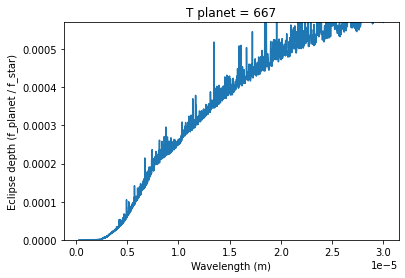

In [18]:
p = Profile()
p.set_isothermal(planet_temp)

calc = EclipseDepthCalculator(method="xsec") #"ktables" for correlated k
wavelengths, depths = calc.compute_depths(p, Rstar, Mplanet, Rplanet , star_temp, stellar_blackbody= blackbody)

# Generate picture
plt.plot(wavelengths, depths)

plt.ylim(depths[0]/2, depths[-1]+ depths[0])

plt.title(f'T planet = {planet_temp}')
plt.xlabel('Wavelength (m)')
plt.ylabel('Eclipse depth (f_planet / f_star)')

plt.savefig(f"{datapath}/platon/{filename}.png")
plt.show()


# change values of wavelengths and depths into numpy array
# correct wavelength value to unit pandexo can use
wavelengths = np.array(wavelengths) * 100
depths = np.array(depths)


data = np.column_stack([wavelengths, depths])
datafile_path = f'{datapath}/platon/{filename}.txt'
np.savetxt(datafile_path , data, fmt=['%2.10f','%2.45f'])


Pandexo\
This next cell creates the pickle file for the JWST simulation.\
The input for this one can be inputted in the constants cell


In [19]:
# Running pandexo

exo_dict = jdi.load_exo_dict()

exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 2 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 2 * transit_duration #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 0   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = star_magnitude               #magnitude of the system
exo_dict['star']['ref_wave'] = ref_wave        #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = star_temp             #in K
exo_dict['star']['metal'] = metalicity             # as log Fe/H
exo_dict['star']['logg'] = logg             #log surface gravity cgs

exo_dict['planet']['type'] = 'constant'                  #tells pandexo you want a fixed transit depth

exo_dict['planet']['transit_duration'] = transit_duration   #transit duration
exo_dict['planet']['td_unit'] = 's'

exo_dict['star']['radius'] = Rstar / R_sun
exo_dict['star']['r_unit'] = 'R_sun'    

exo_dict['planet']['type'] ='user'                       #tells pandexo you are uploading your own spectrum
exo_dict['planet']['exopath'] = f'{datapath}/platon/{filename}.txt'
exo_dict['planet']['w_unit'] = 'cm'                      #other options include "um","nm" ,"Angs", "sec" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'               #other options are 'fp/f*'


# generates a string with all the instruments
inststr = ''
for i in inst_list:
    inststr += i[-5:]

result = jdi.run_pandexo(exo_dict, inst_list, output_file= f"{datapath}/pandexo/{filename}.p")

Running Single Case for: NIRSpec G140H
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [25]:
# Visualising Pandexo

out = pk.load(open(f"{datapath}/pandexo/{filename}.p", 'rb'))


list_out = []

if len(inst_list) > 1:
    for i in range(len(inst_list)):
        list_out.append(out[i][inst_list[i]])

else:
    list_out = out


x,y, e = jpi.jwst_1d_spec(list_out, title = pandexo_title, R = pandexo_R, num_tran = pandexo_num_tran, model = pandexo_model, x_range = pandexo_x_range, output_file=f'{datapath}/pandexo/{filename}.html')


In [26]:
HTML(filename=f'{datapath}/pandexo/{filename}.html')